# EDA which makes sense for prediction of poisonous mushrooms

This notebook shows
- how the data contains strange values
- how to cross-validate a model
- how to call gradient-boosting models
- how to preprocess the data for a neural network and how to train the neural network
- how to ensemble the models

References:
- Competition: https://www.kaggle.com/competitions/playground-series-s4e8
- Original data: https://archive.ics.uci.edu/dataset/73/mushroom or better https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset

In [1]:
# TargetEncoder
!pip install -q scikit-learn==1.4
# KerasClassifier
!pip install -q --no-deps scikeras
# Original dataset
!pip install -q ucimlrepo


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
import datetime
from colorama import Fore, Style
import lightgbm
import xgboost
import catboost
from scikeras.wrappers import KerasClassifier
import keras
from ucimlrepo import fetch_ucirepo 
import scipy.special

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, PolynomialFeatures, QuantileTransformer, TargetEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import HistGradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import matthews_corrcoef, accuracy_score, log_loss, ConfusionMatrixDisplay, confusion_matrix

2024-08-03 09:39:39.510218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 09:39:39.510395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 09:39:39.656003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Configuration
# Produce a submission file (you can set this to false if you only
# want to see the cross-validation results)
COMPUTE_TEST_PRED = True

# Speed up training by using only a subset of the data (set this
# to false if you submit the results to the competition)
USE_SUBSET = False

# Containers for results
oof, test_pred, fold_scores = {}, {}, {}

# Reading the data

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col='id')
if USE_SUBSET:
    train = train.sample(200000)
original = fetch_ucirepo(id=848)['data']['original']
test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col='id')

targets = train.pop('class')
targets_bool = targets == 'p'
initial_features = list(test.columns)
print(f"Train shape: {train.shape}")
print(f"Original data shape: {original.shape}")
print(f"Test shape:  {test.shape}")
train.head()

Train shape: (3116945, 20)
Original data shape: (61069, 21)
Test shape:  (2077964, 20)


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
0,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [5]:
train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3116945 entries, 0 to 3116944
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   cap-diameter          3116941 non-null  float64
 1   cap-shape             3116905 non-null  object 
 2   cap-surface           2445922 non-null  object 
 3   cap-color             3116933 non-null  object 
 4   does-bruise-or-bleed  3116937 non-null  object 
 5   gill-attachment       2593009 non-null  object 
 6   gill-spacing          1858510 non-null  object 
 7   gill-color            3116888 non-null  object 
 8   stem-height           3116945 non-null  float64
 9   stem-width            3116945 non-null  float64
 10  stem-root             359922 non-null   object 
 11  stem-surface          1136084 non-null  object 
 12  stem-color            3116907 non-null  object 
 13  veil-type             159452 non-null   object 
 14  veil-color            375998 non-null  

# First observations

- With three million rows, the training dataset is huge. To save time, we'll do most experiments with a simple train-test split rather than five-fold cross-validation. And with this large amount of data, we'll focus on gradient-boosted tree models and neural networks.
- Most features have missing values. We'll either use models which can deal with missing values natively, or we'll have to impute the missing values.
- Most features are categorical. We can experiment with one-hot encoding and target encoding.
- The features do not correspond to the features explained in https://archive.ics.uci.edu/dataset/73/mushroom but to those from https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset.

The dataset is messy. According to the description, `cap-shape` should have the following categories:

>  bell=b, conical=c, convex=x, flat=f, knobbed=k, sunken=s

In the dataset, `cap-shape` has many more categories:


In [6]:
with pd.option_context("display.max_rows", 200):
    display(test['cap-shape'].value_counts(dropna=False))

cap-shape
x               957949
f               452360
s               242698
b               211879
o                71972
p                71302
c                69436
e                   33
NaN                 31
d                   30
t                   28
w                   27
n                   27
a                   24
y                   24
u                   18
l                   17
k                   17
g                   17
r                   16
z                    8
m                    4
i                    4
h                    3
is f                 2
3.32                 1
3.94                 1
2.7                  1
3.15                 1
5.05                 1
cap-diameter         1
4.51                 1
4.86                 1
0.97                 1
6.47                 1
6.52                 1
3.23                 1
2.02                 1
1.53                 1
8                    1
6.15                 1
17.89                1
0.74                 1
9

We'll convert the data types to speed up processing and save memory:
- All categorical features will be converted to the pandas categorical dtype. Values which don't occur in the original dataset are replaced by np.nan.
- All float features will be converted to float32



In [7]:
# Convert to categorical or float32
float_features = ['cap-diameter', 'stem-height', 'stem-width']
cat_features = [f for f in initial_features if f not in float_features]
for feature in initial_features:
    if feature in cat_features:
        categories = sorted(list(set(original[feature].dropna())))
        dtype = pd.CategoricalDtype(categories=categories,
                                    ordered=False)
        print(f"{feature:30} {len(dtype.categories)}")
        train.loc[~train[feature].isin(categories), feature] = np.nan
        if COMPUTE_TEST_PRED:
            test.loc[~test[feature].isin(categories), feature] = np.nan
    else:
        dtype = np.float32
    train[feature] = train[feature].astype(dtype)
    original[feature] = original[feature].astype(dtype)
    if COMPUTE_TEST_PRED:
        test[feature] = test[feature].astype(dtype)
        

cap-shape                      7
cap-surface                    11
cap-color                      12
does-bruise-or-bleed           2
gill-attachment                7
gill-spacing                   3
gill-color                     12
stem-root                      5
stem-surface                   8
stem-color                     13
veil-type                      1
veil-color                     6
has-ring                       2
ring-type                      8
spore-print-color              7
habitat                        8
season                         4


# The target

The target is binary and balanced.


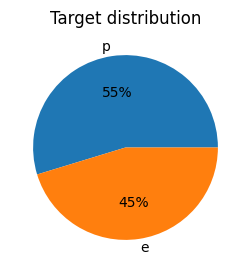

In [8]:
temp = targets.value_counts()
temp

plt.figure(figsize=(6, 3))
plt.pie(temp, labels=temp.index, autopct="%.0f%%")
plt.title('Target distribution')
plt.show()

# The features

The feature histograms show:
- There are three continuous features (plotted in green for the synthetic data and orange for the original data), which may have some outliers in the high values.
- Categorical features are plotted in black for the synthetic data and orange for the original data. The leftmost bar is for the missing values.
- Train and original data have similar distributions.

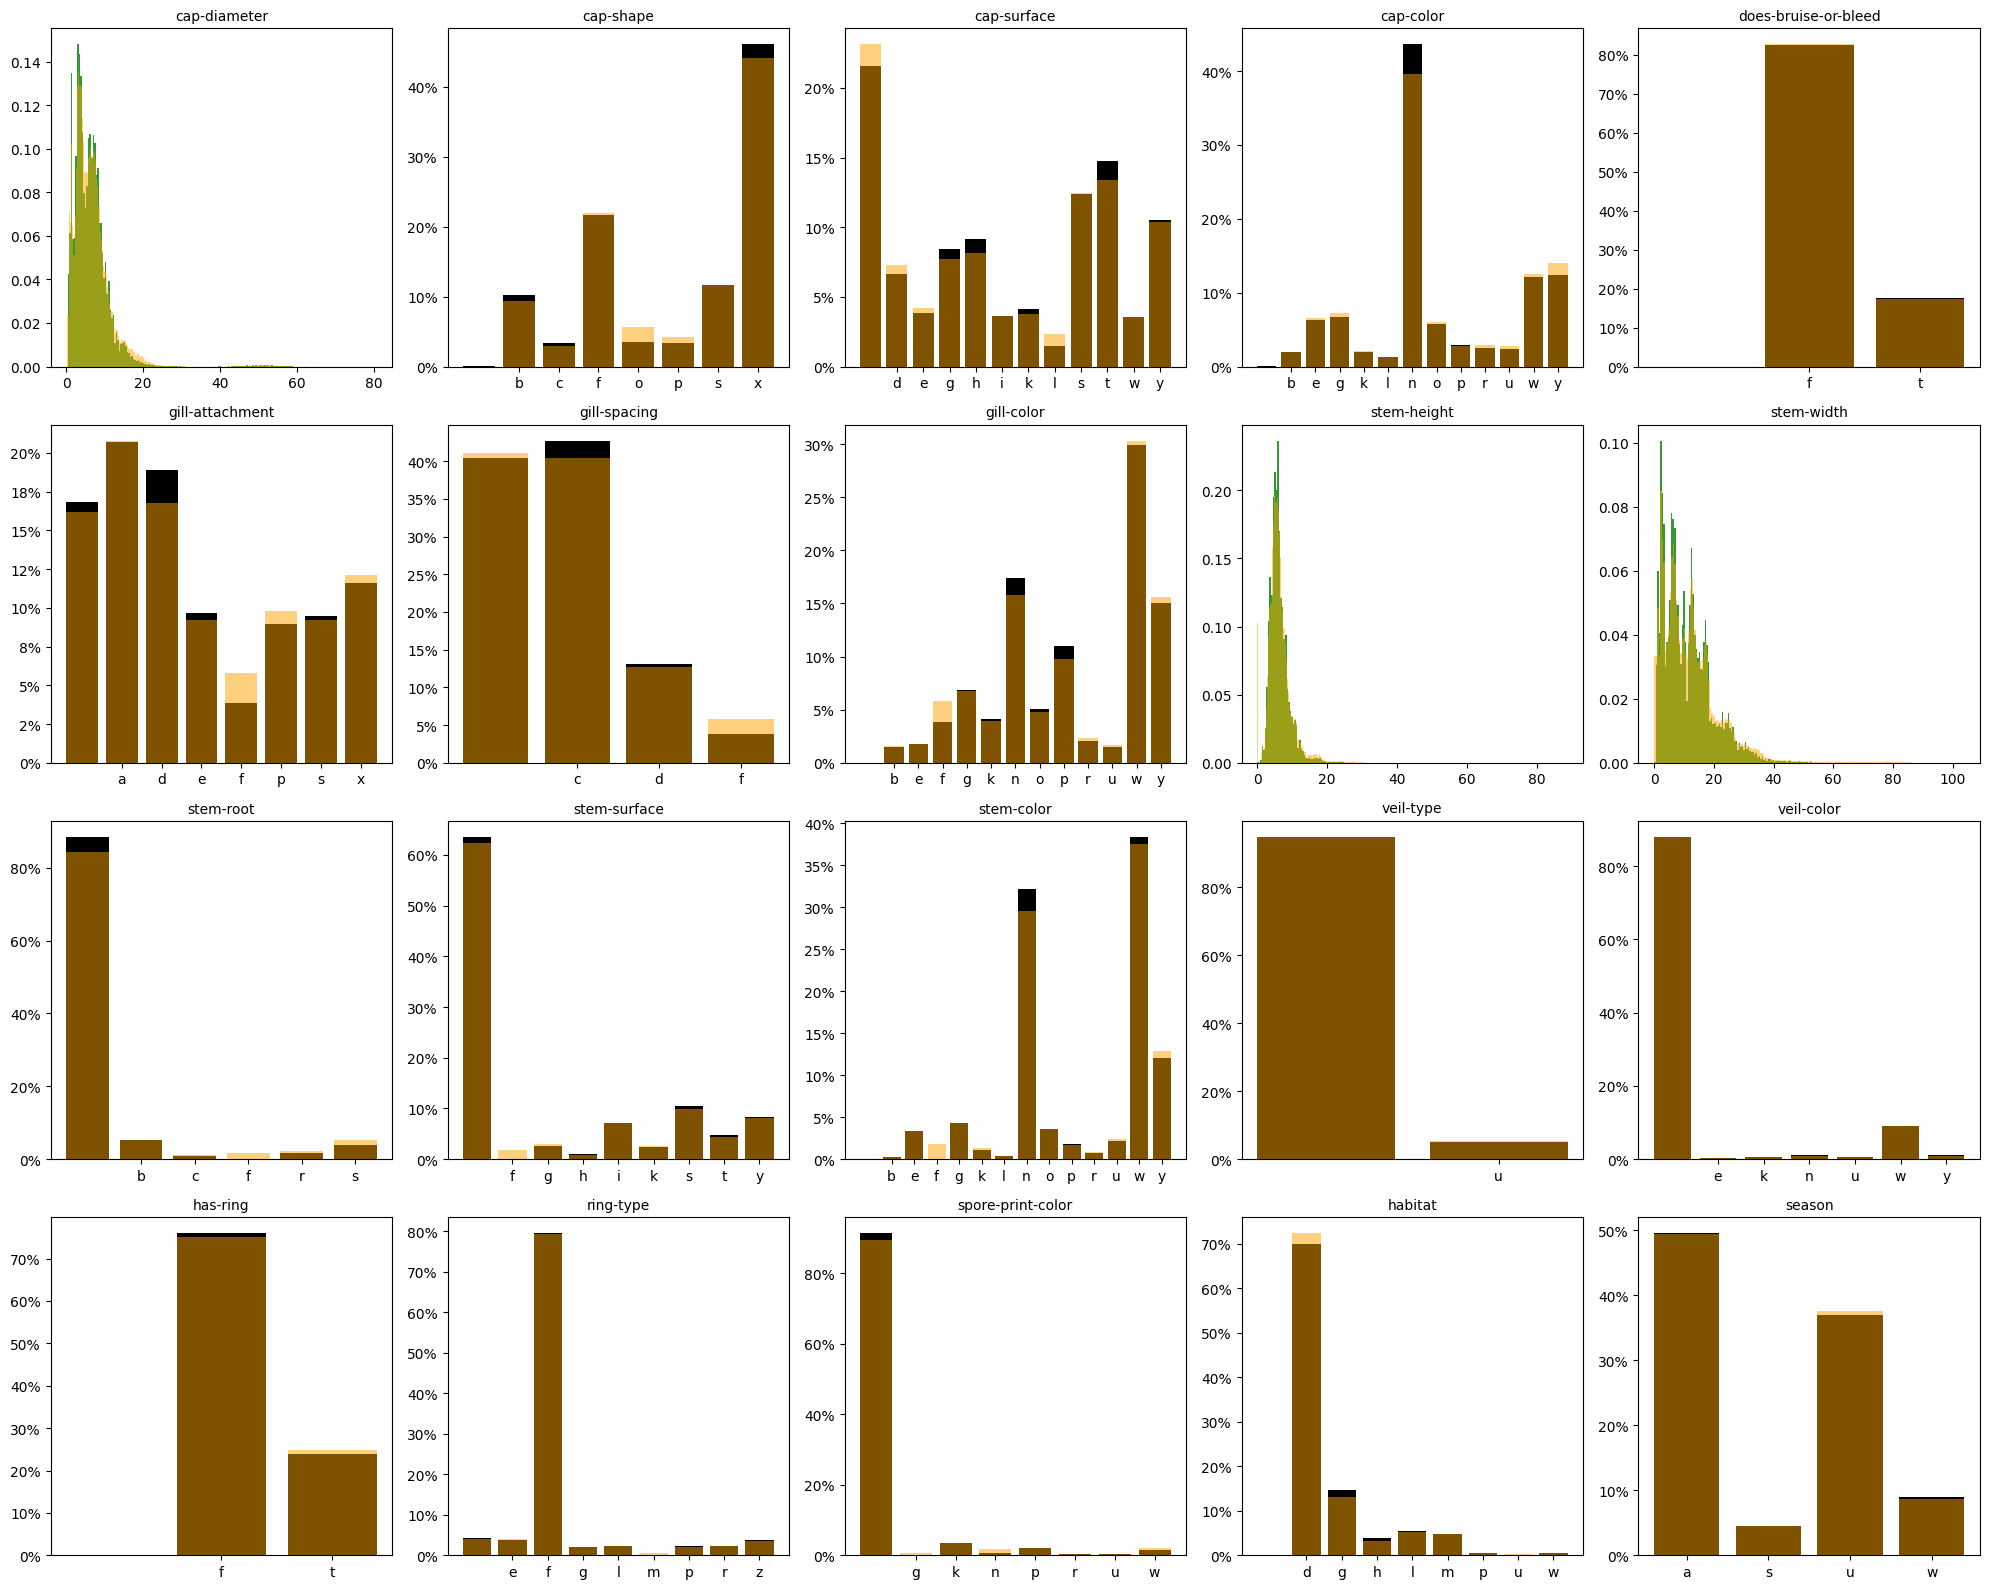

CPU times: user 7.44 s, sys: 326 ms, total: 7.77 s
Wall time: 7.28 s


In [9]:
%%time
_, axs = plt.subplots(4, 5, figsize=(20, 16))
for col, ax in zip(initial_features, axs.ravel()):
    if col in ['cap-diameter', 'stem-height', 'stem-width']: # float
        ax.hist(train[col], bins=200, density=True, color='g', alpha=0.8)
        ax.hist(original[col], bins=200, density=True, color='orange', alpha=0.5)
    elif train[col].dtype == 'category':
        vc = train[col].cat.codes.value_counts() / len(train)
        ax.bar(vc.index, vc, color='k')
        vc = original[col].cat.codes.value_counts() / len(original)
        ax.bar(vc.index, vc, color='orange', alpha=0.5)
        ax.yaxis.set_major_formatter('{x:.0%}')
        if len(vc) <= 15:
            ax.set_xticks(np.arange(len(train[col].dtype.categories)), train[col].dtype.categories)
        else:
            ax.set_xticks([])
    ax.set_title(f"{col}", fontsize=10)
plt.tight_layout()
plt.show()
del axs, ax, vc


# Important features

We can try to determine the most important features by looking at plots of shallow decision trees, but the two decision trees in the following notebook cells (with and without target encoding) disagree on the most important features.

Because `DecisionTreeClassifier` can't deal with categorical features and missing values, we convert the categorical features and impute the missing values in a pipeline.

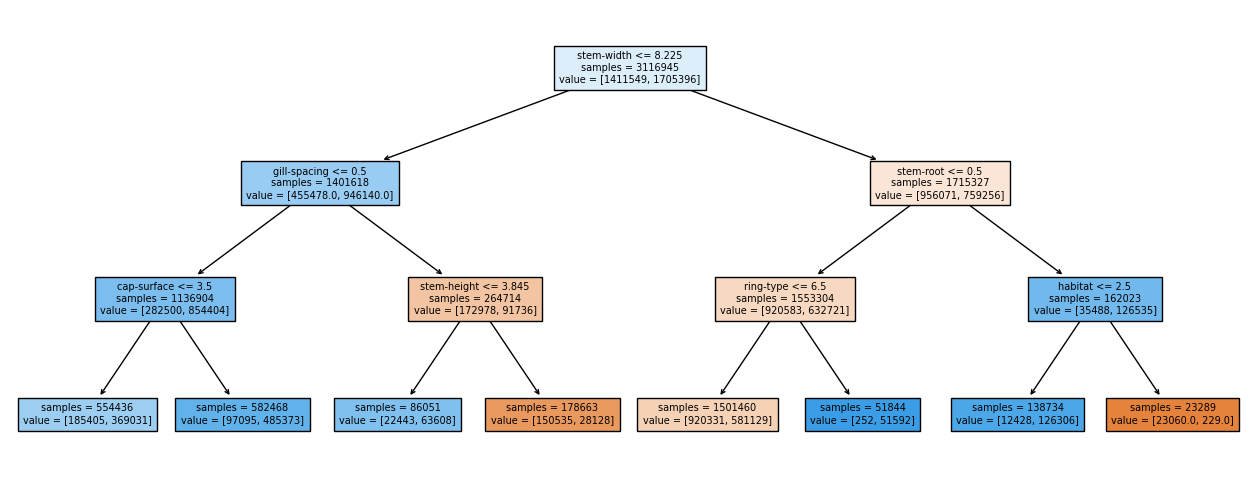

CPU times: user 27.6 s, sys: 333 ms, total: 27.9 s
Wall time: 27.6 s


In [10]:
%%time
# Plot shallow decision tree
def to_codes(df):
    return pd.DataFrame({col: df[col].cat.codes for col in df.columns})

model = make_pipeline(ColumnTransformer([('cat',
                                          FunctionTransformer(to_codes),
                                          train.select_dtypes('category').columns),
                                        ],
                                        remainder=SimpleImputer().set_output(transform='pandas'),
                                        verbose_feature_names_out=False).set_output(transform='pandas'),
                      DecisionTreeClassifier(max_depth=3, min_samples_leaf=100))
model.fit(train[initial_features], targets);

plt.figure(figsize=(16, 6))
plot_tree(model[-1], feature_names=model[-1].feature_names_in_, fontsize=7, impurity=False, filled=True, ax=plt.gca())
plt.show()



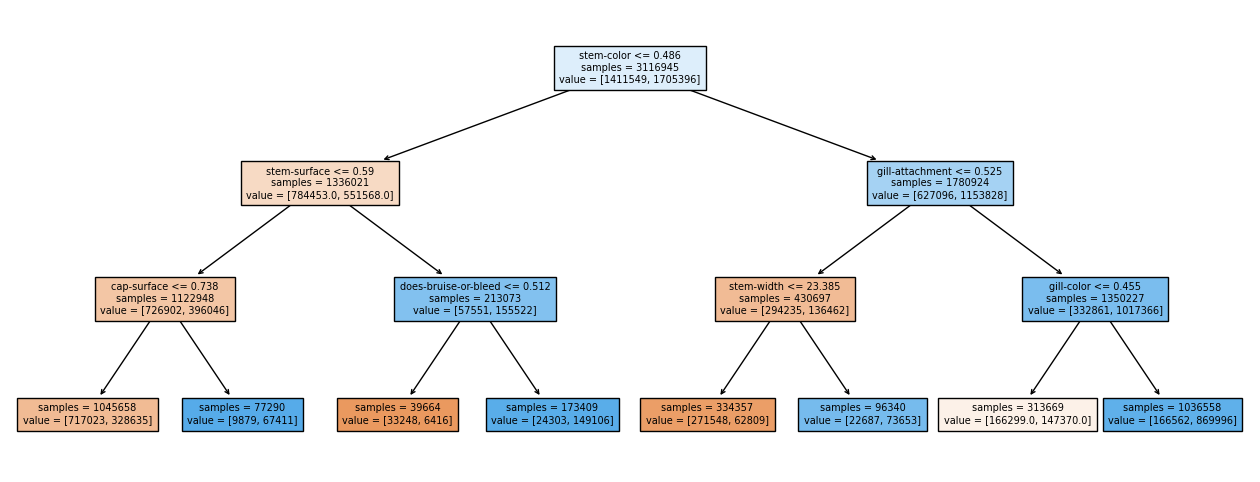

CPU times: user 1min 16s, sys: 1.71 s, total: 1min 18s
Wall time: 1min 18s


In [11]:
%%time
# Plot shallow decision tree
model = make_pipeline(ColumnTransformer([('cat',
                                          TargetEncoder(),
                                          train.select_dtypes('category').columns),
                                        ],
                                        remainder=SimpleImputer().set_output(transform='pandas'),
                                        verbose_feature_names_out=False).set_output(transform='pandas'),
                      DecisionTreeClassifier(max_depth=3, min_samples_leaf=100))
model.fit(train[initial_features], targets);

plt.figure(figsize=(16, 6))
plot_tree(model[-1], feature_names=model[-1].feature_names_in_, fontsize=7, impurity=False, filled=True, ax=plt.gca())
plt.show()



# Cross-validation

As the dataset is large, we run only the first fold of the cross-validation. We augment the training dataset by the original data although I'm unsure whether the original data bring any added value.

In [12]:
crossval_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

def cross_validate(model, label, 
                   features=initial_features,
                   fit_params={},
                   plot_histogram=False,
                   use_eval_set=False,
                   use_original=True):
    """Compute out-of-fold and test predictions for a given model.
    
    Out-of-fold and test predicted probabilities are stored in the global variables
    oof and test_pred, respectively, so that they can later be used for stacking
    the models in an ensemble.
    """
    start_time = datetime.datetime.now()
    global X_va, y_va
    scores = []
    oof_proba = np.full(len(train), np.nan, dtype=np.float32)
    for fold, (idx_tr, idx_va) in enumerate(crossval_kf.split(train, targets)):
        X_tr = train.iloc[idx_tr][features]
        y_tr = targets_bool.iloc[idx_tr]
        X_va = train.iloc[idx_va][features]
        y_va = targets_bool.iloc[idx_va]
        
        if use_original:
            # Add the original data to the training data
            X_tr = pd.concat([X_tr, original[features]], axis=0)
            y_tr = pd.concat([y_tr, original['class'] == 'p'])
            rng = np.random.default_rng()
            permutation = rng.permutation(len(X_tr))
            X_tr = X_tr.iloc[permutation]
            y_tr = y_tr.iloc[permutation]
            
        if use_eval_set: fit_params['eval_set'] = [(X_va, y_va)]
        model.fit(X_tr, y_tr, **fit_params)
        
        y_pred_proba = model.predict_proba(X_va)[:,1]
        
        if plot_histogram:
            plt.figure(figsize=(8, 2))
            plt.hist(y_pred_proba, bins=500, density=True)
            plt.xlabel('predicted probability')
            plt.ylabel('density')
            plt.title('Histogram of predicted probabilities')
            plt.show()

        y_pred = y_pred_proba >= 0.5
        score = matthews_corrcoef(y_va, y_pred)
        print(f"# Fold {fold}: mcc={score:.5f}")
        scores.append(score)
        oof_proba[idx_va] = y_pred_proba

        break # one fold is enough
            
    elapsed_time = datetime.datetime.now() - start_time
    if not (np.isnan(oof_proba)).any():
        mcc = matthews_corrcoef(targets_bool, oof_proba >= 0.5)
        logloss = log_loss(targets_bool, oof_proba)   
        print(f"{Fore.GREEN}# Overall: mcc={mcc:.5f}"
              f" logloss={logloss:.5f} {label}"
              f"   {int(np.round(elapsed_time.total_seconds() / 60))} min{Style.RESET_ALL}")
    else:
        print(f"{Fore.GREEN}# {label}"
              f"   {int(np.round(elapsed_time.total_seconds() / 60))} min{Style.RESET_ALL}")
    oof[label] = oof_proba
    fold_scores[label] = scores
    
    if COMPUTE_TEST_PRED:
        X_tr = train[features]
        y_tr = targets_bool

        if use_eval_set: del fit_params['eval_set']
        model.fit(X_tr, y_tr, **fit_params)
        test_pred[label] = model.predict_proba(test[features])[:,1]

# Models

We just fit some models without much hyperparameter tuning to verify the cross-validation code.

The competition metric, the Matthews correlation coefficient (MCC), returns values between -1 and +1, and higher is better. The models give almost perfect predictions with a very high MCC. 

Our first model is LightGBM. Its hyperparameters have been tuned by Optuna.

In [13]:
# LightGBM
lgbm_params = {'boosting_type': 'gbdt', 'learning_rate': 0.12388465676255876, 
               'n_estimators': 232, 'colsample_bytree': 0.6224503470954874, 
               'reg_lambda': 80.31410618524352, 'min_child_samples': 41, 
               'num_leaves': 489, 'verbose': -1}
model = lightgbm.LGBMClassifier(**lgbm_params)
cross_validate(model, 'LGBM')

# Fold 0: mcc=0.98476
# LGBM   3 min


In [14]:
# DART
lgbm_params = {'boosting_type': 'dart', 'learning_rate': 0.305,
               'n_estimators': 140, 'colsample_bytree': 0.63,
               'reg_lambda': 64.8, 'min_child_samples': 26, 
               'num_leaves': 235, 'verbose': -1}

model = lightgbm.LGBMClassifier(**lgbm_params)
cross_validate(model, 'DART')
# cross_validate(model, 'DART', use_eval_set=True,
#                fit_params={'callbacks': [lightgbm.log_evaluation(5)]})

# Fold 0: mcc=0.98469
# DART   13 min


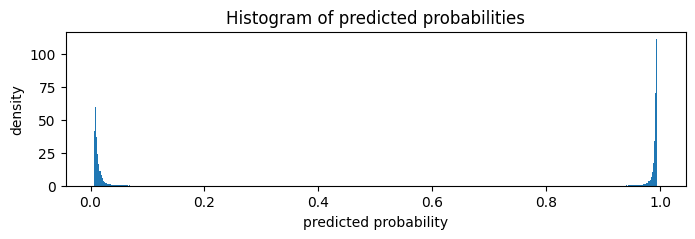

# Fold 0: mcc=0.98466
# XGB   6 min


In [15]:
# XGBoost
xgb_params = {'grow_policy': 'depthwise', 'learning_rate': 0.06750932713805277,
              'n_estimators': 68, 'max_depth': 20, 'reg_lambda': 0.27,
              'min_child_weight': 4.952710346179816, 'subsample': 0.953, 
              'colsample_bytree': 0.7539110455959812, 'tree_method': 'hist',
              'enable_categorical': True, 'gamma': 0}
model = xgboost.XGBClassifier(**xgb_params)
cross_validate(model, 'XGB', plot_histogram=True)
# cross_validate(model, 'XGB', use_eval_set=True)

The histogram of the predicted probabilities shows that most predicted probabilities are near 0.0 or 1.0: Our classification models are very confident.

In [16]:
# HistGradientBoostingClassifier
# HistGradientBoostingClassifier uses early stopping
model = HistGradientBoostingClassifier(max_iter=1000,
                                       learning_rate=0.05,
                                       max_leaf_nodes=1024,
                                       max_features=0.6,
                                       min_samples_leaf=40,
                                       categorical_features='from_dtype',
                                       verbose=0)
cross_validate(model, 'HGB')
print(f"# Iterations: {model.n_iter_}")


# Fold 0: mcc=0.98464
# HGB   7 min
# Iterations: 173


Our final model is a neural network implemented in Keras. It is a sequential network with two hidden layers. As neural networks cannot deal with categorical features and missing values, we use a pipeline which one-hot encodes the categorical values and imputes the missing values.

See [Don't neglect neural networks!](https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523531) for a discussion about the importance of neural networks in this competition.

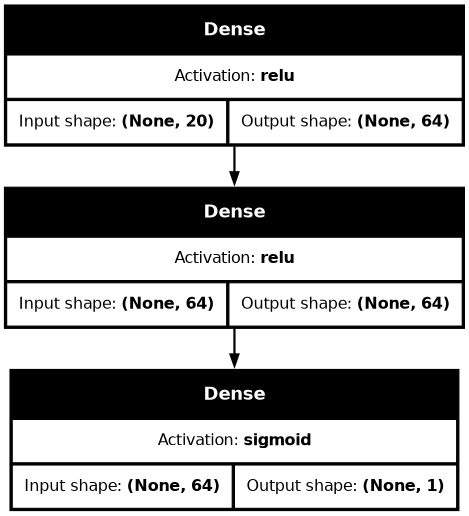

# Fold 0: mcc=0.98438
# Keras   33 min


In [17]:
# Neural network (Keras) with two hidden layers (one-hot encoded)
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

display(keras.utils.plot_model(get_model({"X_shape_": train.shape}),
                       show_shapes=True, show_layer_activations=True, dpi=80))


clf = KerasClassifier(
    get_model,
    loss="binary_crossentropy",
    optimizer=keras.optimizers.AdamW(learning_rate=0.01),
    validation_split=0.03,
    batch_size=8192,
    validation_batch_size=65536,
    epochs=50,
    verbose=0, # or 2
    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3),
               keras.callbacks.EarlyStopping(patience=5, min_delta=0.00003)]
)

model = make_pipeline(ColumnTransformer([('float', make_pipeline(PowerTransformer(),
                                                                 SimpleImputer(add_indicator=True)),
                                          float_features),
                                         ('cat', OneHotEncoder(drop='first',
                                                               sparse_output=False,
                                                               dtype=np.float32,
                                                               handle_unknown='infrequent_if_exist',
                                                               min_frequency=50),
                                          cat_features),
                                        ]),
                      StandardScaler(),
                      BaggingClassifier(clf, n_estimators=7, bootstrap=False))
cross_validate(model, 'Keras')
del model, clf


# Ensembling

In [18]:
%%time
# Stacking with logistic regression
X = np.column_stack([oof[label] for label in oof.keys() if 'Ensemble' not in label]).astype(np.float64).clip(1e-15, 1-1e-15)
mask = ~ np.isnan(X).any(axis=1)
if COMPUTE_TEST_PRED:
    X_te = np.column_stack([test_pred[label] for label in oof.keys() if 'Ensemble' not in label]).astype(np.float64).clip(1e-15, 1-1e-15)
model = make_pipeline(FunctionTransformer(scipy.special.logit), LogisticRegression(max_iter=500))
oof['Ensemble (logistic)'] = np.full(len(X), np.nan)
oof['Ensemble (logistic)'][mask] = cross_val_predict(model,
                                               X[mask], targets_bool[mask],
                                               cv=crossval_kf, method='predict_proba')[:,1]
print(f"{Fore.GREEN}# Stacking ensemble (logistic)"
      f" mcc={matthews_corrcoef(targets_bool[mask], oof['Ensemble (logistic)'][mask] >= 0.5):.5f}"
      f" logloss={log_loss(targets_bool[mask], oof['Ensemble (logistic)'][mask]):.5f}{Style.RESET_ALL}")

model.fit(X[mask], targets_bool[mask])
print(pd.Series(model[-1].coef_.ravel(), index=[label for label in oof.keys() if 'Ensemble' not in label], name='weights'))

if COMPUTE_TEST_PRED:
    test_pred['Ensemble (logistic)'] = model.predict_proba(X_te)[:,1]


# Stacking ensemble (logistic) mcc=0.98503 logloss=0.03547
LGBM     0.240660
DART     0.181349
XGB      0.151959
HGB      0.215549
Keras    0.237976
Name: weights, dtype: float64
CPU times: user 17.2 s, sys: 10.3 s, total: 27.5 s
Wall time: 8.68 s


# Evaluation

The bar chart shows the scores of all models.

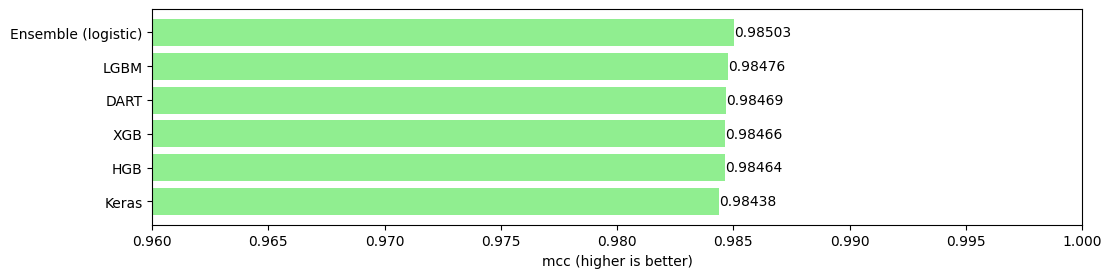

In [19]:
result_list = []
for label in oof.keys():
    mask = ~np.isnan(oof[label])
    score = matthews_corrcoef(targets_bool[mask], oof[label][mask] >= 0.5)
    result_list.append((label, score))
result_df = pd.DataFrame(result_list, columns=['label', 'score'])
result_df.sort_values('score', inplace=True, ascending=False)

plt.figure(figsize=(12, len(result_df) * 0.4 + 0.4))
bars = plt.barh(np.arange(len(result_df)), result_df.score, color='lightgreen')
plt.gca().bar_label(bars, fmt='%.5f')
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.gca().invert_yaxis()
plt.xlim(0.96, 1.0)
plt.xlabel(f'mcc (higher is better)')
plt.show()


# Submission

In [20]:
if COMPUTE_TEST_PRED:
    sub = pd.Series(np.where(test_pred[result_df['label'].iloc[0]] >= 0.5, 'p', 'e'),
                    index=test.index,
                    name='class')
    sub.to_csv('submission.csv')
    !head submission.csv

id,class
3116945,e
3116946,p
3116947,p
3116948,p
3116949,e
3116950,e
3116951,e
3116952,p
3116953,p


# Next steps

- Improve the architecture of the neural network
- Tune the hyperparameters of the models more
